In [1]:
# !pip install seaborn
# !pip install matplotlib
# !pip install tqdm
# !pip install sklearn2
# !pip install opencv-python
# !pip install torch
# !pip install torchvision 
# !pip install albumentations
# !pip install efficientnet-pytorch
# !pip install pandas
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [1]:
# System
import cv2
import os, os.path
import gc
import time
import datetime

# Basics
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    
# %matplotlib inline
from tqdm.notebook import tqdm      
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate)
from albumentations.pytorch import ToTensorV2#, ToTensor

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50, inception_v3, mobilenet_v2
from efficientnet_pytorch import EfficientNet
import tqdm
import warnings
warnings.filterwarnings("ignore")
print(torch.__version__)


1.10.0+cu113


In [2]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available',torch.cuda.device_count())
print('Device available now:', device)

Device available 8
Device available now: cuda


In [3]:
#SET WHICH GPU TO USE
torch.cuda.set_device(0)

In [30]:
train_df = pd.read_csv('DL_IMG_Train.csv', sep = ';', usecols =['id','PatientSex','Age','cT','cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])
test_df = pd.read_csv('DL_IMG_Test.csv', sep = ';', usecols =['id','PatientSex','Age','cT','cN','adj_ctx','RT_scop_interval','ALL_CR_yesno'])

test_df.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)

train_cols = train_df.columns[:]
train_df = train_df[train_cols]

test_cols = test_df.columns[:]
test_df = test_df[test_cols]


print('Len Train: {:,}'.format(len(train_df)), '\n' +
      'Len Test: {:,}'.format(len(test_df)), '\n' +
      'All Train+Test: {:,}'.format(len(train_df)+len(test_df)))

test_df.head()

Len Train: 571 
Len Test: 151 
All Train+Test: 722


,id,ALL_CR_yesno,PatientSex,Age,cT,cN,adj_ctx,RT_scop_interval
0,./Scopy_restaging_new/202/Restaging/0001046540...,1,0,64,3,0,0.0,8.0
1,./Scopy_restaging_new/202/Restaging/0001046540...,1,0,64,3,0,0.0,8.0
2,./Scopy_restaging_new/202/Restaging/0001046540...,1,0,64,3,0,0.0,8.0
3,./Scopy_restaging_new/202/Restaging/0001046540...,1,0,64,3,0,0.0,8.0
4,./Scopy_restaging_new/203/Restaging/0081612238...,1,0,68,2,1,0.0,22.0


In [31]:
# selected features
csv_columns = ['cN', 'adj_ctx', 'RT_scop_interval']
no_columns = 3

# preprocessing(crop images)

In [32]:
# ----- STATICS -----
vertical_flip = 0.5
horizontal_flip = 0.5

image_size = 299
batch_size = 3

In [4]:
def crop_margin(img):
       img2=img.sum(axis=2)
       (row,col) = img2.shape
       row_top   = 0
       row_down  = 0
       col_top   = 0
       col_down  = 0
       for r in range(0,row):
           if img2.sum(axis=1)[r]>50*col:
              row_top = r
              break
       for r in range(row-1,0,-1):
           if img2.sum(axis=1)[r]>50*col:
              row_down=r
              break
       for c in range(0,col):
           if img2.sum(axis=0)[c]>50*col:
              col_top=c
              break
       for c in range(col-1,0,-1):
           if img2.sum(axis=0)[c]>50*col:
              col_down=c
              break
       new_img=img[row_top:row_down+1,col_top:col_down+1,0:3]
       return new_img
   

def center_crop(img, portion):
       (row, col, cha) = img.shape
       row_top         = int(row*(1-portion)/2-1)
       row_down        = int(row*(portion+0.5*(1-portion))-1)
       col_top         = int(col*(1-portion)/2-1)
       col_down        = int(col*(portion+0.5*(1-portion))-1)
       new_img         = img[row_top:row_down+1, col_top:col_down+1,0:3]
       return new_img
   
def zero_center(img, R, G, B):
       img[:, :, 0] -= R
       img[:, :, 1] -= G
       img[:, :, 2] -= B
       return img
    
def normalize(img, v):
       new_img = cv2.normalize(img, None, 0, v, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
       return new_img   
   
def random_crop_img(image, crop_portion=0.6, random_seed=0):
       if crop_portion <= 0 or crop_portion > 1:
           return None
       height, width = image.shape[:-1]
       crop_size = [int(height*crop_portion), int(width*crop_portion)]
       dy, dx = crop_size
       X = np.copy(image)
       np.random.seed(random_seed)
       x = np.random.randint(0, width - dx + 1)
       y = np.random.randint(0, height - dy + 1)
       aX = X[y:(y + dy - 1), x:(x + dx - 1), :]
       img_crop = sci.imresize(aX, (height, width, 3), 'cubic')
       return img_crop



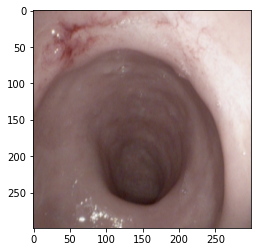

In [11]:
# show image
image = cv2.imread(test_df['id'][10])
image = image[:, :, [2, 1, 0]]
image = crop_margin(image)
image = center_crop(image, 0.8)
image = cv2.resize(image, (image_size, image_size))
imshow(image)

In [5]:
class EndoscopyDataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True, is_valid=False, is_test=False):
        self.dataframe, self.is_train, self.is_valid = dataframe, is_train, is_valid
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        # Data Augmentation 
        if is_train or is_test:
            self.transform = Compose([RandomResizedCrop(height=image_size, width=image_size, scale=(0.4, 1.0)),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      HueSaturationValue(sat_shift_limit=[0.7, 1.3], 
                                                         hue_shift_limit=[-0.1, 0.1]),
                                      RandomBrightnessContrast(brightness_limit=[0.7, 1.3],
                                                               contrast_limit= [0.7, 1.3]),
                                      Normalize(),
                                      ToTensorV2()])
        else:
            self.transform = Compose([Normalize(),
                                      ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        # Select path and read image
        image_path = self.dataframe['id'][index]
        image = cv2.imread(image_path)
        image = crop_margin(image)
        image = center_crop(image, 0.8)
        image = cv2.resize(image, (image_size, image_size))
        csv_data = np.array(self.dataframe.iloc[index][['cN', 'adj_ctx', 'RT_scop_interval']].values, dtype=np.float32)
                            



        # Apply transforms
        image = self.transform(image=image)
        # Extract image from dictionary
        image = image['image']
        
        # If train/valid: image + class | If test: only image
        if self.is_train or self.is_valid:
            return (image, csv_data), self.dataframe['ALL_CR_yesno'][index]
        else:
            return (image, csv_data)

# CNN Model

In [6]:
output_size = 1

class Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        # Uncomment which network you would like to train on
        
#         self.features = resnet50(pretrained=True) # 1000 neurons out
#         self.features = mobilenet_v2(pretrained=True) # 1000 neurons out
#         self.features = densenet121(pretrained=True) # 1000 neurons out
#         self.features = inceptionresnetv2() # 1000 neurons out
#         self.features = inception_v3(pretrained=True, aux_logits=False) # 1000 neurons out
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
    
    
        # (CSV data)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 50),
                                 nn.BatchNorm1d(50),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 50, output_size)
        
        
    def forward(self, image, csv_data, prints=False):
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints: print('CSV Data:', csv_data.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        # CLASSIF
        out = self.classification(image_csv_data)
        if prints: print('Out shape:', out.shape)
        
        return out

# Train


In [14]:
# ----- STATICS -----
train_len = len(train_df)
test_len = len(test_df)
# -------------------

# Out of Fold Predictions
oof = np.zeros(shape = (train_len, 1))

# Predictions
preds_submission = torch.zeros(size = (test_len, 1), dtype=torch.float32, device=device)

print('oof shape:', oof.shape, '\n' +
      'predictions shape:', preds_submission.shape)

oof shape: (571, 1) 
predictions shape: torch.Size([151, 1])


### Combined model architecture
images/combined_model_architecture.jpg
![](images/combined_model_architecture.jpg)

In [9]:
# ----- Prain parameters -----
epochs = 50
patience = 3
num_workers = 8
learning_rate = 0.0005
weight_decay = 0.01
lr_patience = 1            
lr_factor = 0.6      

batch_size = 6
batch_size1 = 32
batch_size2 = 16

k = 5 # cross validation folds           

version = 'v2'            

## Cross validation

In [37]:
group_fold = GroupKFold(n_splits = k)

# Generate indices to split data into training and test set.
folds = group_fold.split(X = np.zeros(train_len), 
                         y = train_df['ALL_CR_yesno'], 
                         groups = train_df['id'].tolist())

## Combined model construction

In [10]:

def train_folds(preds_submission, model, version = 'v1'):
    # Creates a .txt file that will contain the logs
    f = open(f"logs_{version}.txt", "w+")
    
    
    for fold, (train_index, valid_index) in enumerate(folds):
        # Append to .txt
        with open(f"logs_{version}.txt", 'a+') as f:
            print('-'*10, 'Fold:', fold+1, '-'*10, file=f)
        print('-'*10, 'Fold:', fold+1, '-'*10)


        # --- Create Instances ---
        # Best ROC score in this fold
        best_roc = None
        # Reset patience before every fold
        patience_f = patience
        
        # Initiate the model
        model = model

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=lr_patience, verbose=True, factor=lr_factor)
        criterion = nn.BCEWithLogitsLoss()


        # --- Read in Data ---
        train_data = train_df.iloc[train_index].reset_index(drop=True)
        valid_data = train_df.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = EndoscopyDataset(train_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=True, is_valid=False, is_test=False)
        valid = EndoscopyDataset(valid_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=False, is_valid=True, is_test=False)
        test = EndoscopyDataset(test_df, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip,
                               is_train=False, is_valid=False, is_test=True)

        # Dataloaders
        train_loader = DataLoader(train, batch_size=batch_size1, shuffle=True, num_workers=num_workers)
        valid_loader = DataLoader(valid, batch_size=batch_size2, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test, batch_size=batch_size2, shuffle=False, num_workers=num_workers)

        
        history = []
       
        # === EPOCHS ===
        for epoch in range(epochs):
            start_time = time.time()
            correct = 0
            train_losses = 0
            valid_losses = 0            
            train_losses_avg = 0
            valid_losses_avg = 0

            # === TRAIN ===
            # Sets the module in training mode.
            model.train()

            for (images, csv_data), labels in train_loader:
                # Save them to device
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                labels = torch.tensor(labels, device=device, dtype=torch.float32)

                # Clear gradients first; very important, usually done BEFORE prediction
                optimizer.zero_grad()

                # Log Probabilities & Backpropagation
                out = model(images, csv_data)
                loss = criterion(out, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()

                # --- Save information after this batch ---
                # Save loss
                train_losses += loss.item() * images.size(0)
                         
                
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)

            train_losses_avg = train_losses / len(train_index)

            # === EVAL ===
            # Sets the model in evaluation mode
            model.eval()

            # Create matrix to store evaluation predictions 
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)


            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                for k, ((images, csv_data), labels) in enumerate(valid_loader):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                    labels = torch.tensor(labels, device=device, dtype=torch.float32)

                    out = model(images, csv_data)
                    pred = torch.sigmoid(out)
                    valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

                    loss = criterion(out, labels.unsqueeze(1))
                    # --- Save information after this batch ---
                    # Save loss
                    valid_losses += loss.item() * images.size(0)                                
                
                valid_losses_avg = valid_losses / len(valid_index)                    
                    
                # Compute accuracy
                valid_acc = accuracy_score(valid_data['ALL_CR_yesno'].values, 
                                           torch.round(valid_preds.cpu()))
                # Compute ROC
                valid_roc = roc_auc_score(valid_data['ALL_CR_yesno'].values, 
                                          valid_preds.cpu())

                # Compute time on Train + Eval
                duration = str(':')

                history.append([train_losses_avg, valid_losses_avg, train_acc, valid_acc]) 

    
                # PRINT INFO
                # Append to .txt file
                with open(f"logs_{version}.txt", 'a+') as f:
                    print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc), file=f)
                # Print to console
                print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc))



                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)

                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(), 
                               f"Model_Fold{fold+1}.pth")
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = patience
                    torch.save(model.state_dict(), 
                               f"Model_Fold{fold+1}.pth")
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        with open(f"logs_{version}.txt", 'a+') as f:
                            print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                  format(best_roc), file=f)
                        print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                              format(best_roc))
                        #  break


        best_model_path = 'trained_model/best_model.pth'

        # === INFERENCE ===
        # Choose model with best_roc in this fold
        best_model_path = './' + [file for file in os.listdir('.') if 'Fold'+str(fold+1) in file][0]
        # Using best model from Epoch Train

        model = Network(output_size=output_size, no_columns=no_columns).to(device)

        model.load_state_dict(torch.load(best_model_path))
        # Set the model in evaluation mode
        model.eval()


        with torch.no_grad():
            # --- EVAL ---
            # Predicting again on Validation data to get preds for OOF
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)

            for k, ((images, csv_data), _) in enumerate(valid_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                out = model(images, csv_data)
                pred = torch.sigmoid(out)
                valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

            # Save info to OOF
            oof[valid_index] = valid_preds.cpu().numpy()


            # --- TEST ---
            for k, (images, csv_data) in enumerate(test_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                out = model(images, csv_data)
                # Covert to probablities
                out = torch.sigmoid(out)

                # ADDS! the prediction to the matrix we already created
                preds_submission[k*images.shape[0] : k*images.shape[0] + images.shape[0]] += out

        y_pred_list = [a.squeeze().tolist() for a in torch.round(preds_submission).cpu()]

               
        # Compute accuracy
        valid_acc = accuracy_score(test_df['ALL_CR_yesno'].values, y_pred_list)

        # Compute ROC
        valid_roc = roc_auc_score(test_df['ALL_CR_yesno'].values, 
                                          preds_submission.cpu())                
              

        # === CLEANING ===
        # Clear memory
        del train, valid, train_loader, valid_loader, images, labels
        # Garbage collector
        gc.collect()

## Train

In [28]:
#use single GPU
model = Network(output_size=output_size, no_columns=no_columns).to(device)

# # ===== Train =====
train_folds(preds_submission = preds_submission, model = model, version = version)

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
: | Epoch: 1/50 | Loss: 317.5 | Train Acc: 0.583 | Valid Acc: 0.548 | ROC: 0.684
: | Epoch: 2/50 | Loss: 304.8 | Train Acc: 0.621 | Valid Acc: 0.652 | ROC: 0.709
: | Epoch: 3/50 | Loss: 293.3 | Train Acc: 0.623 | Valid Acc: 0.617 | ROC: 0.697
: | Epoch: 4/50 | Loss: 284.7 | Train Acc: 0.649 | Valid Acc: 0.661 | ROC: 0.711
: | Epoch: 5/50 | Loss: 293.4 | Train Acc: 0.625 | Valid Acc: 0.617 | ROC: 0.716
: | Epoch: 6/50 | Loss: 284.4 | Train Acc: 0.647 | Valid Acc: 0.635 | ROC: 0.715
: | Epoch: 7/50 | Loss: 279.4 | Train Acc: 0.673 | Valid Acc: 0.643 | ROC: 0.712
Epoch     7: reducing learning rate of group 0 to 3.0000e-04.
: | Epoch: 8/50 | Loss: 276.8 | Train Acc: 0.656 | Valid Acc: 0.678 | ROC: 0.712
Early stopping (no improvement since 3 models) | Best ROC: 0.7155434122647236
: | Epoch: 9/50 | Loss: 276.1 | Train Acc: 0.667 | Valid Acc: 0.661 | ROC: 0.715
Epoch     9: reducing learning rate of group 0 to 1.800